# SimpegEM1D VTEM Waveform

In [1]:
from simpegEM1D import *

In [2]:
from SimPEG import *
import numpy as np

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:

dobs = np.load('dobs_3d.npy')

In [5]:
time_channels = np.vstack([
    [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    [470e-7, 598e-7, 726e-7, 886e-7, 1118e-7, 1454e-7, 1852e-7, 2344e-7, 2952e-7, 3706e-7, 4644e-7, 5814e-7, 7278e-7, 9112e-7, 11170e-7, 14292e-7, 17912e-7, 22460e-7, 28174e-7, 35356e-7, 44388e-7, 55750e-7, 7.00e-03, 8.80e-03]
]).T

In [6]:
waveform = np.vstack([
    np.r_[-10, -9.29, -8.41, -7.26, -5.28, -3.62, -2.33, -0.62, 0.00, 0.0266, 0.0276, 0.0286, 10.000]*1e-3,
    np.r_[0, 20, 40, 60, 80, 90, 95, 99, 100, 1.53, 0.566, 0.000, 0.000]/100.
]).T

In [7]:
time_input_currents = waveform[:-1, 0]
input_currents = waveform[:-1, 1]
times = time_channels[:-3, 1]

In [8]:
print(time_input_currents)

[-1.00e-02 -9.29e-03 -8.41e-03 -7.26e-03 -5.28e-03 -3.62e-03 -2.33e-03
 -6.20e-04  0.00e+00  2.66e-05  2.76e-05  2.86e-05]


In [9]:
print(input_currents)

[0.      0.2     0.4     0.6     0.8     0.9     0.95    0.99    1.
 0.0153  0.00566 0.     ]


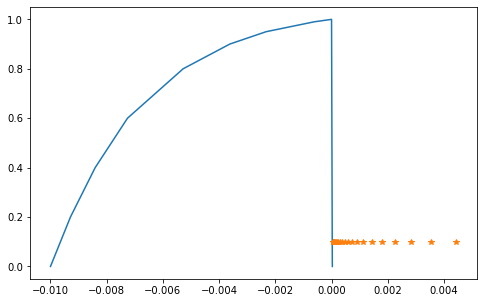

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(time_input_currents, input_currents)
ax.plot(times,0.1*np.ones(len(times)),'*')
#plt.rcParams.update({'font.size': 16})

In [11]:
area = 313.98
radius = np.sqrt(area/np.pi)
system_height = 39.8
rxloc = np.array([0, 0., 100+system_height], dtype=float)
srcloc = np.array([0., 0., 100+system_height], dtype=float)


In [12]:
print(radius)

9.997146496075098


In [13]:
type(rxloc)

numpy.ndarray

In [14]:
# cs,csz, ncx, ncz, npad = 5.0,1.0, 25, 31,17
# hz = [ (csz, ncz), (cs, npad, 1.3)]
# hz = get_vertical_discretization_time(times, facter_tmax=0.5, factor_tmin=10.)
hz = get_vertical_discretization_time(times, sigma_background=0.01, facter_tmax=1, n_layer=40)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigz = -mesh1D.gridCC


In [15]:
#np.save('vectorCCx',mesh1D.vectorCCx)

In [16]:
TDsurvey = EM1DSurveyTD(
    rx_location = rxloc,
    src_location = srcloc,
    topo = np.r_[0.,0.,100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = radius,
    time = times,
    input_currents = input_currents,
    time_input_currents = time_input_currents,
    base_frequency=50,
    n_pulse=1
    )

In [17]:
sig_half = 1e-1
chi_half =0.
expmap = Maps.ExpMap(mesh1D)

In [18]:
sig = np.ones(TDsurvey.n_layer)*sig_half
m0 = np.log(sig)
print(m0)

[-2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509 -2.30258509
 -2.30258509 -2.30258509 -2.30258509 -2.30258509]


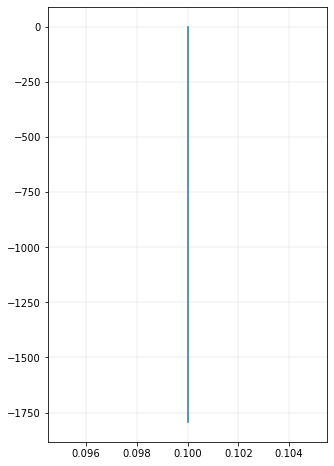

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5, 8))
ax.plot(sig,depth)
ax.grid(which = 'major', linestyle='-', linewidth=0.2)

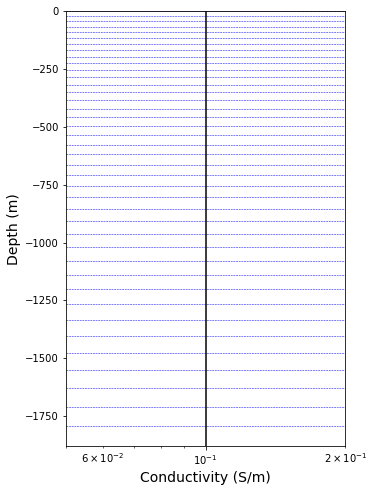

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=True)
#ax.set_ylim(-100,0)


In [21]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_0 = TDsurvey.dpred(m0)/area

Wall time: 150 ms


In [22]:
std = 0.05
floor = 1e-12
uncert = abs(dobs) * std + floor

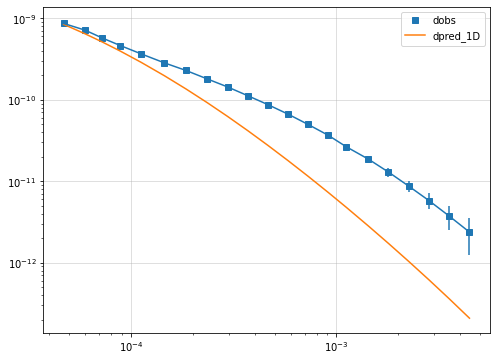

In [23]:
fig, ax = plt.subplots(1, 1,figsize=(8,6))

ax.loglog(time_channels[:-3, 1], dobs, "C0s", label="dobs")
plt.errorbar(time_channels[:-3, 1], dobs, yerr=uncert, color="C0")
ax.loglog(time_channels[:-3, 1], -d_0, "C1", label="dpred_1D")
ax.grid('k', alpha=0.5)
ax.legend()

In [24]:
TDsurvey.dobs = -dobs
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
dmisfit.W = 1./ uncert


SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [50]:
reg = Regularization.Tikhonov(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1e-3,
    alpha_x=1.
)
opt = Optimization.InexactGaussNewton(maxIter=50)
opt.LSshorten = 0.5
opt.remember('xc')

invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
target = Directives.TargetMisfit()  # stop when we hit target misfit
invProb.beta = 5.
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
inv = Inversion.BaseInversion(invProb, directiveList=[target])
# run the inversion



In [51]:
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+00  9.77e+07  0.00e+00  9.77e+07    1.17e+08      0              
   1  5.00e+00  1.40e+07  6.14e-02  1.40e+07    1.33e+07      0              
   2  5.00e+00  2.75e+06  2.54e-01  2.75e+06    2.01e+06      0   Skip BFGS  
   3  5.00e+00  5.99e+05  6.66e-01  5.99e+05    3.58e+05      0   Skip BFGS  
   4  5.00e+00  1.42e+05  1.36e+00  1.42e+05    6.82e+04      0   Skip BFGS  
   5  5.00e+00  3.45e+04  2.41e+00  3.45e+04    1.30e+04      0   Skip BFGS  
   6  5.00e+00  5.48e+03  5.09e+00  5.50e+03    4.92e+03      0   

Text(0.5, 0, 'Resistivity (ohm-m)')

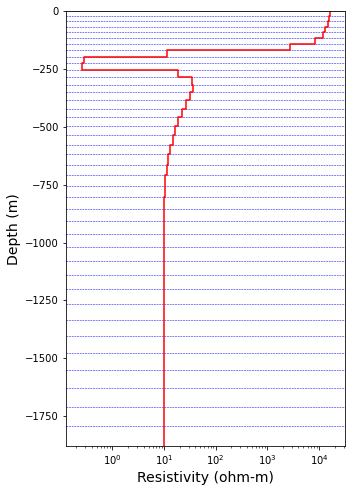

In [52]:
fig, ax = plt.subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./(expmap*mopt), mesh1D, showlayers=True, **{'color':'r'})
plt.xlabel("Resistivity (ohm-m)")
# Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1.})

In [53]:
dpred = invProb.dpred
dpred.shape

(21,)

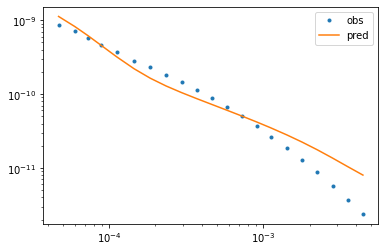

In [54]:
plt.loglog(times, -TDsurvey.dobs, '.')
plt.loglog(times, -invProb.dpred)
plt.legend(("obs", "pred"))
